<small><i>Updated February 2025 - This notebook was created by [Santi Seguí](https://ssegui.github.io/). </i></small>

# Let's create a Non-Personalised Recommender using MovieLens Dataset
We will work with the well known MovieLens dataset (http://grouplens.org/datasets/movielens/). This dataset was initially constructed to support participants in the Netflix Prize. Today, we can find several versions of this dataset with different amout of data, from 100k samples version to 20m sample version. Although performance on bigger dataset is expected to be better, we will work with the smallest dataset: MovieLens 1M Dataset (ml-1m.zip). Working with this lite version has the benefit of less computational costs

With a unix machine the dataset can be downloaded with the following code:


## 📥 1. Download and Load the Data
The dataset can be downloaded from [GroupLens](http://grouplens.org/datasets/movielens/).  
If you are using **Linux or macOS**, you can download it with:

If you are using Windows, download it manually and extract it to data/ml-1m/.

## 📊 2. Load Data into Pandas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
u_cols = ['user_id', 'sex', 'age', 'occupation', 'zip_code']
users = pd.read_csv('./ml-1m/users.dat', sep='::', names=u_cols, engine='python')

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('./ml-1m/ratings.dat', sep='::', names=r_cols, engine='python')

m_cols = ['movie_id', 'title', 'genre']
movies = pd.read_csv('./ml-1m/movies.dat', sep='::', names=m_cols, usecols=[0,1,2], encoding='latin-1', engine='python')

# Merge datasets
data = ratings.merge(users, on="user_id").merge(movies, on="movie_id")
data = data[['user_id', 'title', 'movie_id', 'rating', 'genre', 'sex', 'age']]

# General info
n_users = data.user_id.nunique()
n_items = data.movie_id.nunique()

print(f"📌 Total ratings: {data.shape[0]}")
print(f"📌 Total users: {n_users}")
print(f"📌 Total movies: {n_items}")

data.head()

📌 Total ratings: 1000209
📌 Total users: 6040
📌 Total movies: 3706


,user_id,title,movie_id,rating,genre,sex,age
0,1,One Flew Over the Cuckoo's Nest (1975),1193,5,Drama,F,1
1,1,James and the Giant Peach (1996),661,3,Animation|Children's|Musical,F,1
2,1,My Fair Lady (1964),914,3,Musical|Romance,F,1
3,1,Erin Brockovich (2000),3408,4,Drama,F,1
4,1,"Bug's Life, A (1998)",2355,5,Animation|Children's|Comedy,F,1


## 📈 3. Dataset Exploration

If you explore the dataset in detail, you will see that it consists of:

1.000.209 ratings from 6040 users of 3706 movies. Ratings are from 1 to 5.
Simple demographic info for the users (age, gender, occupation, zip)

In [4]:
print(f"📌 Average interactions per user: {data.shape[0] / n_users:.2f}")
print(f"📌 Average interactions per movie: {data.shape[0] / n_items:.2f}")
print(f"📌 Dataset sparsity: {(1 - data.shape[0] / (n_users * n_items)) * 100:.2f}%")

📌 Average interactions per user: 165.60
📌 Average interactions per movie: 269.89
📌 Dataset sparsity: 95.53%


### Ranking by polularity
We compute the item popularity as the number of interaction in each column

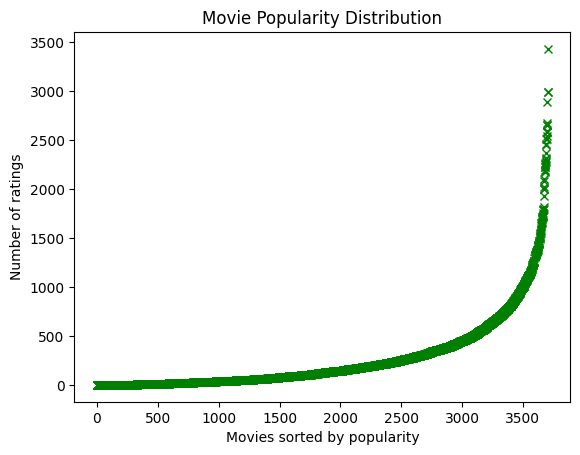

In [5]:
mean_score = data.groupby("movie_id").agg(mean_rating=("rating", "mean"), num_ratings=("movie_id", "count"))
item_popularity = mean_score.sort_values("num_ratings")["num_ratings"].values

plt.plot(item_popularity, 'gx')
plt.title("Movie Popularity Distribution")
plt.xlabel("Movies sorted by popularity")
plt.ylabel("Number of ratings")
plt.show()

We compute the average per-item interaction

In [6]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 269.89
Average per-item interactions for the top 10% popular items 1199.74
Average per-item interactions for the least 10% popular items 2.85
Average per-item interactions for the median 10% popular items 123.66


### We compute the user activity (profile length) as the number of interaction in each row

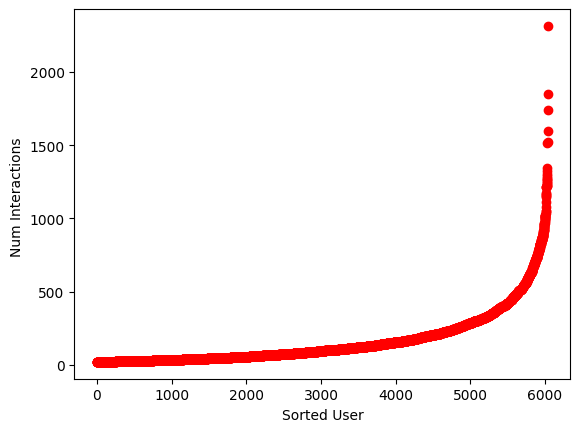

In [7]:
user_activity = data[['user_id','rating']].groupby(['user_id']).size()
user_activity = np.sort(user_activity.values)

plt.plot(user_activity, 'ro')
plt.ylabel('Num Interactions ')
plt.xlabel('Sorted User')
plt.show()

In [8]:
data[['user_id','rating']].groupby(['user_id']).size()

user_id
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

## 🏆 4. Creating a Non-Personalized Recommender System

In order to create a Recommender we have to define:
* A splitting of the data
* An evaluation metric
* A function to evaluate for each user

### 📌 Data Spitting 
The splitting of the data is very important to ensure your algorithm is evaluated in a realistic scenario by using test it has never seen. 
We create two splits:
* Train
* Test

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=7)

### 📌 Evaluation Metrics
We call items in the test set 'relevant'


In [10]:
# These are the relevat items for one user
user_id = 1
relevant_items = test[test.user_id==user_id].movie_id.values
relevant_items

array([1207, 1566, 1287,  938,  745, 2294])

In [11]:
# let's imagin our recommender sytes recommend the following item
recommended_items = np.array([241, 2028, 114, 857, 1823])
recommended_items

array([ 241, 2028,  114,  857, 1823])

In [12]:
is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
is_relevant

/var/folders/2p/jhwrh6nd31d66nltvznxjsm00000gn/T/ipykernel_35080/4100743327.py:1: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)


array([False, False, False, False, False])

We can use several metrics.  These are some of the most classical ones:
* Precision
* Recall
* Average Precison


#### Precision: how many of the recommended items are relevant

In [13]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.isin(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

#### Recall: how many of the relevant items I was able to recommend

In [14]:
def recall(recommended_items, relevant_items):
    
    is_relevant = np.isin(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

#### Average Precision

In [15]:
def AP(recommended_items, relevant_items):
   
    is_relevant = np.isin(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

## 🎲 5. Implementing a (naive) Recommendation Strategy

Now that we have the data, we can build our first recommender. A **RANDOM RECOMMENDER SYSTEM** We will need a:
* a'fit' function to train our model
* a 'predict_top' function that uses our model to recommend the top movies for the user

### 🔹 1. Random Recommender

In [16]:
class RandomRecommender():

    def fit(self, train):
        
        self.items = train.title.unique()
    
    def predict_top(self, user_id, at=5):
    
        recommended_items = np.random.choice(self.items, at, replace = False)
        return recommended_items

Testing the recommender: 

In [17]:
randomRecommender = RandomRecommender()
randomRecommender.fit(train)

for user_id in range(3):
    print("********* Recommended items **********\n",randomRecommender.predict_top(user_id, at=5))

********* Recommended items **********
 ['Stalker (1979)' 'Cabinet of Dr. Ramirez, The (1991)'
 "Mummy's Curse, The (1944)" 'Barenaked in America (1999)'
 'Orlando (1993)']
********* Recommended items **********
 ['Held Up (2000)' 'Basic Instinct (1992)' 'Repulsion (1965)'
 'Kramer Vs. Kramer (1979)' 'Courage Under Fire (1996)']
********* Recommended items **********
 ['Where the Heart Is (2000)' 'Dream for an Insomniac (1996)'
 'Being John Malkovich (1999)' 'Die Hard 2 (1990)' 'Flubber (1997)']


## 🏁 6. Model Evaluation

In [18]:
# We pass as a parameter the recommender class
def evaluate_algorithm(test, recommender_object, at=5):
    cumulative_precision, cumulative_recall, cumulative_AP = 0.0, 0.0, 0.0
    num_eval = 0

    for user_id in test.user_id.unique():
        relevant_items = test[test.user_id==user_id].title.values
    
        if len(relevant_items)>0:
            recommended_items = recommender_object.predict_top(user_id, at=at)
            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            num_eval+=1
            
    print(f"🔹 Precision: {cumulative_precision / num_eval:.4f}")
    print(f"🔹 Recall: {cumulative_recall / num_eval:.4f}")
    print(f"🔹 MAP: {cumulative_AP / num_eval:.4f}")

In [19]:
evaluate_algorithm(test, randomRecommender)

🔹 Precision: 0.0091
🔹 Recall: 0.0013
🔹 MAP: 0.0044


## 🚀 7. Implementing a (great) Recommendation Strategy

**Everything works but for sure it can be improved..**

### 🔹 TOP POPULAR RECOMMENDER

We recommend to all users the most popular items, that is those with the highest number of interactions
In this case our model is the item popularity


Testing the recommender:

In [20]:
class TopPopRecommender:
    def fit(self, train):
        self.items = train.groupby('title').rating.count().sort_values(ascending=False).index
    def predict_top(self, user_id, at=5):
        return self.items[:at]

In [21]:
topPopRecommender = TopPopRecommender()
topPopRecommender.fit(train)

In [22]:
for user_id in range(3):
    print(topPopRecommender.predict_top(user_id, at=5))

Index(['American Beauty (1999)', 'Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Jurassic Park (1993)'],
      dtype='object', name='title')
Index(['American Beauty (1999)', 'Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Jurassic Park (1993)'],
      dtype='object', name='title')
Index(['American Beauty (1999)', 'Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Jurassic Park (1993)'],
      dtype='object', name='title')


In [23]:
evaluate_algorithm(test, topPopRecommender, at=5)

🔹 Precision: 0.0980
🔹 Recall: 0.0245
🔹 MAP: 0.0556


What if que only recommend unseen movies?

In [24]:
import numpy as np

class TopPopRecommender:
    def fit(self, train):
        self.items = train.groupby('title').rating.count().sort_values(ascending=False).index
        self.train = train

    def predict_top(self, user_id, at=5):
        # Películas que el usuario ya ha visto
        seen_movies = self.train[self.train.user_id == user_id].title.to_numpy()

        # Filtrar solo las no vistas
        top_unseen = self.items[~np.isin(self.items, seen_movies)][:at]
        
        return top_unseen

In [25]:
topPopRecommender_removeSeen = TopPopRecommender()
topPopRecommender_removeSeen.fit(train)

for user_id in range(3):
    print(topPopRecommender_removeSeen.predict_top(user_id, at=5))

Index(['American Beauty (1999)', 'Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Jurassic Park (1993)'],
      dtype='object', name='title')
Index(['American Beauty (1999)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Jurassic Park (1993)', 'Terminator 2: Judgment Day (1991)'],
      dtype='object', name='title')
Index(['Star Wars: Episode IV - A New Hope (1977)', 'Jurassic Park (1993)',
       'Saving Private Ryan (1998)', 'Back to the Future (1985)',
       'Men in Black (1997)'],
      dtype='object', name='title')


In [26]:
evaluate_algorithm(test, topPopRecommender_removeSeen)

🔹 Precision: 0.2086
🔹 Recall: 0.0389
🔹 MAP: 0.1515


In [27]:
globalAverage = train.rating.mean()
print("The global average is {:.2f}".format(globalAverage))

The global average is 3.58


In [28]:
globalAverage = train.rating.mean()
print("The global average is {:.2f}".format(globalAverage))

The global average is 3.58


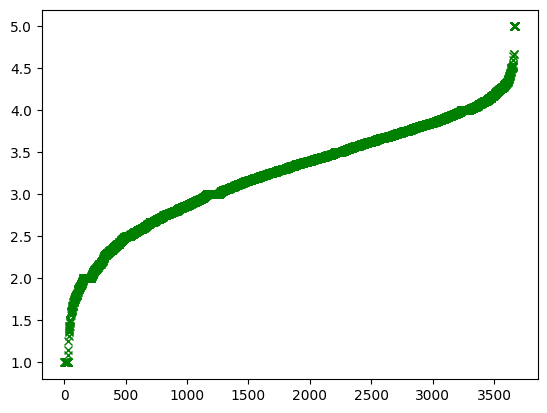

In [29]:
mean_item_rating = train[['movie_id','rating']].groupby(by ='movie_id').mean().rating.values
plt.plot(np.sort(mean_item_rating),'gx')

In [30]:
import numpy as np

class HighestRatedRecommender:
    def fit(self, train):
        self.items = train.groupby('title').rating.mean().sort_values(ascending=False).index
        self.train = train

    def predict_top(self, user_id, at=5):
        # Películas que el usuario ya ha visto
        seen_movies = self.train[self.train.user_id == user_id].title.to_numpy()

        # Filtrar solo las no vistas
        top_unseen = self.items[~np.isin(self.items, seen_movies)][:at]
        
        return top_unseen

In [31]:
highestScoreRecommender_removeSeen = HighestRatedRecommender()
highestScoreRecommender_removeSeen.fit(train)

for user_id in range(3):
    print(highestScoreRecommender_removeSeen.predict_top(user_id, at=5))
    
evaluate_algorithm(test, highestScoreRecommender_removeSeen)

Index(['One Little Indian (1973)', 'Follow the Bitch (1998)',
       'Gate of Heavenly Peace, The (1995)', 'Dancemaker (1998)',
       'Schlafes Bruder (Brother of Sleep) (1995)'],
      dtype='object', name='title')
Index(['One Little Indian (1973)', 'Follow the Bitch (1998)',
       'Gate of Heavenly Peace, The (1995)', 'Dancemaker (1998)',
       'Schlafes Bruder (Brother of Sleep) (1995)'],
      dtype='object', name='title')
Index(['One Little Indian (1973)', 'Follow the Bitch (1998)',
       'Gate of Heavenly Peace, The (1995)', 'Dancemaker (1998)',
       'Schlafes Bruder (Brother of Sleep) (1995)'],
      dtype='object', name='title')
🔹 Precision: 0.0001
🔹 Recall: 0.0000
🔹 MAP: 0.0000


In [32]:
import numpy as np

class HighestRatedRecommender:
    def fit(self, train,k=10):
        self.top = train[['title','rating']].groupby(by ='title').agg([np.size,np.mean])
        self.top['damped_mean'] = (self.top['rating']['mean']*self.top['rating']['size']  + k*train.rating.mean()) / (self.top['rating']['size'] + k)
        self.items = self.top.sort_values(by='damped_mean', ascending=False).index
        print(self.top)
        self.train = train

    def predict_top(self, user_id, at=5):
        # Películas que el usuario ya ha visto
        seen_movies = self.train[self.train.user_id == user_id].title.to_numpy()

        # Filtrar solo las no vistas
        top_unseen = self.items[~np.isin(self.items, seen_movies)][:at]
        
        return top_unseen
        

In [33]:
highestScoreRecommender_removeSeen = HighestRatedRecommender()
highestScoreRecommender_removeSeen.fit(train)

for user_id in range(3):
    print(highestScoreRecommender_removeSeen.predict_top(user_id, at=5))
    
evaluate_algorithm(test, highestScoreRecommender_removeSeen)

                                           rating           damped_mean
                                             size      mean            
title                                                                  
$1,000,000 Duck (1971)                         30  2.900000    3.070333
'Night Mother (1986)                           55  3.309091    3.350974
'Til There Was You (1997)                      39  2.666667    2.853333
'burbs, The (1989)                            241  2.892116    2.919575
...And Justice for All (1979)                 168  3.714286    3.706816
...                                           ...       ...         ...
Zed & Two Noughts, A (1985)                    23  3.434783    3.479191
Zero Effect (1998)                            235  3.829787    3.819646
Zero Kelvin (Kjærlighetens kjøtere) (1995)      2  3.500000    3.567776
Zeus and Roxanne (1997)                        17  2.588235    2.956049
eXistenZ (1999)                               330  3.269697    3

/var/folders/2p/jhwrh6nd31d66nltvznxjsm00000gn/T/ipykernel_35080/3988006827.py:5: FutureWarning: The provided callable <function mean at 0x104d37c40> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  self.top = train[['title','rating']].groupby(by ='title').agg([np.size,np.mean])


🔹 Precision: 0.0754
🔹 Recall: 0.0157
🔹 MAP: 0.0454


In [34]:
def evaluate_algorithm_top(test, recommender_object, at=5, thr_relevant = 4):
    
    cumulative_precision, cumulative_recall, cumulative_AP = 0.0, 0.0, 0.0
    num_eval = 0
    
    for user_id in test.user_id.unique():
        relevant_items = test[(test.user_id==user_id )&( test.rating>=thr_relevant)].title.values
        
        if len(relevant_items)>0:
            recommended_items = recommender_object.predict_top(user_id, at=at)
            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            num_eval+=1
            
    print(f"🔹 Precision: {cumulative_precision / num_eval:.4f}")
    print(f"🔹 Recall: {cumulative_recall / num_eval:.4f}")
    print(f"🔹 MAP: {cumulative_AP / num_eval:.4f}")

In [35]:
def evaluate_algorithm_top(test, recommender_object, at=5, thr_relevant = 4):
    
    cumulative_precision, cumulative_recall, cumulative_AP = 0.0, 0.0, 0.0
    num_eval = 0
    
    for user_id in test.user_id.unique():
        relevant_items = test[(test.user_id==user_id )&( test.rating>=thr_relevant)].title.values
        
        if len(relevant_items)>0:
            recommended_items = recommender_object.predict_top(user_id, at=at)
            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            num_eval+=1
            
    print(f"🔹 Precision: {cumulative_precision / num_eval:.4f}")
    print(f"🔹 Recall: {cumulative_recall / num_eval:.4f}")
    print(f"🔹 MAP: {cumulative_AP / num_eval:.4f}")

In [36]:
## EVALUTE YOUR MODELS WITH THIS NEW STRATEGY

In [4]:
import pandas as pd
from pathlib import Path

Path("processed").mkdir(exist_ok=True)

# -------- ratings --------
r_cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings_10m = pd.read_csv(
    "ml-10m/ratings.dat",
    sep="::",
    names=r_cols,
    engine="python"
)

ratings_10m[["user_id","movie_id","rating"]] = ratings_10m[
    ["user_id","movie_id","rating"]
].astype(float)

ratings_10m.to_parquet(
    "processed/ratings_10m.parquet",
    engine="pyarrow",
    index=False
)

# -------- movies --------
m_cols = ["movie_id", "title", "genres"]
movies_10m = pd.read_csv(
    "ml-10m/movies.dat",
    sep="::",
    names=m_cols,
    encoding="latin-1",
    engine="python"
)

movies_10m.to_parquet(
    "processed/movies_10m.parquet",
    engine="pyarrow",
    index=False
)

print("✅ 10M parquet created")


✅ 10M parquet created


In [6]:
import numpy as np

def precision(recommended_items, relevant_items):
    recommended_items = np.array(recommended_items)
    relevant_items = np.array(relevant_items)
    if recommended_items.size == 0:
        return 0.0
    is_relevant = np.isin(recommended_items, relevant_items, assume_unique=False)
    return float(np.sum(is_relevant, dtype=np.float32) / recommended_items.size)

def recall(recommended_items, relevant_items):
    recommended_items = np.array(recommended_items)
    relevant_items = np.array(relevant_items)
    if relevant_items.size == 0:
        return 0.0
    is_relevant = np.isin(recommended_items, relevant_items, assume_unique=False)
    return float(np.sum(is_relevant, dtype=np.float32) / relevant_items.size)

def AP(recommended_items, relevant_items):
    recommended_items = np.array(recommended_items)
    relevant_items = np.array(relevant_items)
    if recommended_items.size == 0 or relevant_items.size == 0:
        return 0.0

    is_relevant = np.isin(recommended_items, relevant_items, assume_unique=False).astype(np.float32)

    # precision at each k
    p_at_k = is_relevant * (np.cumsum(is_relevant) / (1 + np.arange(is_relevant.shape[0], dtype=np.float32)))
    denom = float(min(relevant_items.shape[0], recommended_items.shape[0]))
    return float(np.sum(p_at_k) / denom)


In [7]:
def evaluate_algorithm_top_movieid(test_df, recommender_object, at=10, thr_relevant=4.0):
    cumulative_precision, cumulative_recall, cumulative_AP = 0.0, 0.0, 0.0
    num_eval = 0

    for user_id in test_df["user_id"].unique():
        relevant_items = test_df[
            (test_df["user_id"] == user_id) & (test_df["rating"] >= thr_relevant)
        ]["movie_id"].values

        if len(relevant_items) == 0:
            continue

        recommended_items = recommender_object.predict_top(user_id, at=at)  # must return movie_id list
        cumulative_precision += precision(recommended_items, relevant_items)
        cumulative_recall += recall(recommended_items, relevant_items)
        cumulative_AP += AP(recommended_items, relevant_items)
        num_eval += 1

    if num_eval == 0:
        return {"precision": 0.0, "recall": 0.0, "map": 0.0}

    return {
        "precision": cumulative_precision / num_eval,
        "recall": cumulative_recall / num_eval,
        "map": cumulative_AP / num_eval
    }


In [9]:
# Parquet + 1M/10M switch + Cold-start + SVD recommender
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split

try:
    import mlflow
    HAS_MLFLOW = True
except Exception:
    HAS_MLFLOW = False

# 0) Switch dataset here
DATASET = "10m"   # "1m" or "10m"

PARQUET = {
    "1m": {
        "ratings": "processed/ratings_1m.parquet",   
        "movies":  "processed/movies_1m.parquet",    
    },
    "10m": {
        "ratings": "processed/ratings_10m.parquet",
        "movies":  "processed/movies_10m.parquet",
    }
}

RANDOM_STATE = 7
TEST_SIZE = 0.2
K_FACTORS = 50
THR_RELEVANT = 4.0
AT = 10

# 10M bigger -> filter more to keep runtime sane
MIN_USER_RATINGS = 5 if DATASET == "1m" else 20
MIN_MOVIE_RATINGS = 5 if DATASET == "1m" else 20

# 1) Load parquet -> build "data" like their notebook
ratings = pd.read_parquet(PARQUET[DATASET]["ratings"])[["user_id","movie_id","rating"]].copy()
ratings["rating"] = pd.to_numeric(ratings["rating"], errors="coerce")
ratings = ratings.dropna(subset=["user_id","movie_id","rating"])
ratings["user_id"] = ratings["user_id"].astype(int)
ratings["movie_id"] = ratings["movie_id"].astype(int)

movies = None
if os.path.exists(PARQUET[DATASET]["movies"]):
    movies = pd.read_parquet(PARQUET[DATASET]["movies"]).copy()
    # normalize col names if needed
    if "genre" in movies.columns and "genres" not in movies.columns:
        movies = movies.rename(columns={"genre": "genres"})
    movies = movies[["movie_id","title"] + (["genres"] if "genres" in movies.columns else [])].copy()
    movies["movie_id"] = movies["movie_id"].astype(int)

# activity filtering 
uc = ratings["user_id"].value_counts()
valid_users = set(uc[uc >= MIN_USER_RATINGS].index)
mc = ratings["movie_id"].value_counts()
valid_movies = set(mc[mc >= MIN_MOVIE_RATINGS].index)

ratings = ratings[ratings["user_id"].isin(valid_users) & ratings["movie_id"].isin(valid_movies)].copy()

# build "data" like their notebook: must include user_id, movie_id, rating, title
if movies is not None:
    data = ratings.merge(movies[["movie_id","title"]], on="movie_id", how="left")
else:
    # if don't have movies parquet, just use movie_id as a "title" placeholder
    data = ratings.copy()
    data["title"] = data["movie_id"].astype(str)

data = data[["user_id","title","movie_id","rating"]].copy()

n_users = data.user_id.nunique()
n_items = data.movie_id.nunique()
print(f"📌 DATASET={DATASET} | ratings={len(data)} | users={n_users} | movies={n_items}")

# split (same as their notebook)
train, test = train_test_split(data, test_size=TEST_SIZE, random_state=RANDOM_STATE)


📌 DATASET=10m | ratings=9984502 | users=69878 | movies=8940


In [10]:
def build_coldstart_ranker_damped_mean(train: pd.DataFrame, k: int = 50):
    """
    Damped mean (Bayesian average):
    score_i = (mean_i * n_i + k * global_mean) / (n_i + k)
    Returns:
      - ranked_movie_ids: np.ndarray sorted by score desc
      - score_table: DataFrame with columns [movie_id, n, mean, score]
      - global_mean
    """
    global_mean = float(train["rating"].mean())

    agg = (
        train.groupby("movie_id")["rating"]
        .agg(n="count", mean="mean")
        .reset_index()
    )
    agg["score"] = (agg["mean"] * agg["n"] + k * global_mean) / (agg["n"] + k)
    agg = agg.sort_values("score", ascending=False)

    ranked_movie_ids = agg["movie_id"].to_numpy()
    return ranked_movie_ids, agg, global_mean


def coldstart_topN(user_id, N, ranked_movie_ids, train_seen_map=None):
    """
    Cold-start policy:
      - unknown user => just return top N from ranked_movie_ids
      - known user but you still want fallback => remove seen if seen map provided
    """
    if train_seen_map is None:
        return ranked_movie_ids[:N].tolist()

    seen = train_seen_map.get(user_id, set())
    out = []
    for mid in ranked_movie_ids:
        if mid not in seen:
            out.append(int(mid))
            if len(out) == N:
                break
    return out


In [11]:
# map: user -> seen movies (TRAIN)
train_seen = train.groupby("user_id")["movie_id"].apply(set).to_dict()

# build damped mean ranker from TRAIN
DAMP_K = 50
cold_ranked_movie_ids, cold_table, global_mean = build_coldstart_ranker_damped_mean(train, k=DAMP_K)


In [14]:

# 2) Global fallback (cold-start user): Top popular unseen / or highest-rated
class TopPopRecommenderRemoveSeen:
    def fit(self, train):
        self.train = train
        # ranked by count
        self.items = train.groupby("movie_id").rating.count().sort_values(ascending=False).index.to_numpy()

    def predict_top(self, user_id, at=10):
        seen = self.train[self.train.user_id == user_id].movie_id.to_numpy()
        top_unseen = self.items[~np.isin(self.items, seen)][:at]
        return top_unseen

topPopCold = TopPopRecommenderRemoveSeen()
topPopCold.fit(train)


# 3) SVD Recommender (same "class + fit + predict_top" style)
#    Cold-start policy: unknown user -> return global top-N from TopPopCold
class SVDRecommender:
    def __init__(self, k_factors=50, cold_fallback=None):
        self.k_factors = k_factors
        self.cold_fallback = cold_fallback  # recommender with predict_top

    def fit(self, train):
        self.train = train

        # mappings from TRAIN only
        self.unique_users = train["user_id"].unique()
        self.unique_movies = train["movie_id"].unique()
        self.user2idx = {u: i for i, u in enumerate(self.unique_users)}
        self.movie2idx = {m: i for i, m in enumerate(self.unique_movies)}
        self.idx2movie = {i: m for m, i in self.movie2idx.items()}

        self.n_users = len(self.user2idx)
        self.n_items = len(self.movie2idx)

        # build sparse rating matrix (TRAIN)
        u_idx = train["user_id"].map(self.user2idx).values
        i_idx = train["movie_id"].map(self.movie2idx).values
        r = train["rating"].values.astype(np.float32)

        R = csr_matrix((r, (u_idx, i_idx)), shape=(self.n_users, self.n_items))
        self.global_mean = float(train["rating"].mean())

        # item mean centering
        item_sum = np.array(R.sum(axis=0)).ravel()
        item_cnt = np.diff(R.tocsc().indptr)
        self.item_means = np.zeros_like(item_sum, dtype=np.float32)
        nz = item_cnt > 0
        self.item_means[nz] = (item_sum[nz] / item_cnt[nz]).astype(np.float32)

        r_centered = r - self.item_means[i_idx]
        R_centered = csr_matrix((r_centered, (u_idx, i_idx)), shape=(self.n_users, self.n_items))

        # SVD
        U, s, Vt = svds(R_centered, k=self.k_factors)
        order = np.argsort(s)[::-1]
        s = s[order]; U = U[:, order]; Vt = Vt[order, :]

        self.pred_centered = U @ (np.diag(s) @ Vt)  

        # watched set
        self.train_watched = train.groupby("user_id")["movie_id"].apply(set).to_dict()

        return self

    def predict_score(self, user_id, movie_id):
        # unknown user/movie return something deterministic
        if user_id not in self.user2idx or movie_id not in self.movie2idx:
            return self.global_mean
        u = self.user2idx[user_id]
        i = self.movie2idx[movie_id]
        pred = float(self.pred_centered[u, i] + self.item_means[i])
        return float(np.clip(pred, 1.0, 5.0))

    def predict_top(self, user_id, at=10):
        # Cold-start user -> global fallback topN
        if user_id not in self.user2idx:
            if self.cold_fallback is None:
                # fallback: most popular in TRAIN
                return self.train.groupby("movie_id").rating.count().sort_values(ascending=False).index.to_numpy()[:at]
            return self.cold_fallback.predict_top(user_id, at=at)

        u = self.user2idx[user_id]
        scores = (self.pred_centered[u, :] + self.item_means).copy()

        seen = self.train_watched.get(user_id, set())
        for mid in seen:
            if mid in self.movie2idx:
                scores[self.movie2idx[mid]] = -np.inf

        top_idx = np.argsort(scores)[-at:][::-1]
        return np.array([self.idx2movie[i] for i in top_idx], dtype=int)

svdRec = SVDRecommender(k_factors=K_FACTORS, cold_fallback=topPopCold)
svdRec.fit(train)

# 4) Evaluate with their evaluate_algorithm_top
#    BUT their code uses title in relevant_items.
#    We'll create a "movie_id-based" eval that matches their logic exactly.
def evaluate_algorithm_top_movieid(test, recommender_object, at=10, thr_relevant=4.0):
    cumulative_precision, cumulative_recall, cumulative_AP = 0.0, 0.0, 0.0
    num_eval = 0

    for user_id in test.user_id.unique():
        relevant_items = test[(test.user_id==user_id) & (test.rating>=thr_relevant)].movie_id.values

        if len(relevant_items) > 0:
            recommended_items = recommender_object.predict_top(user_id, at=at)
            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            num_eval += 1

    print(f"🔹 Precision: {cumulative_precision / num_eval:.4f}")
    print(f"🔹 Recall: {cumulative_recall / num_eval:.4f}")
    print(f"🔹 MAP: {cumulative_AP / num_eval:.4f}")
    return {
        "precision": float(cumulative_precision / num_eval),
        "recall": float(cumulative_recall / num_eval),
        "map": float(cumulative_AP / num_eval),
        "num_eval_users": int(num_eval),
    }

print("\n================ SVD (Top-N) Evaluation ================")
metrics_top = evaluate_algorithm_top_movieid(test, svdRec, at=AT, thr_relevant=THR_RELEVANT)

# RMSE on TEST (one-rating prediction) to satisfy leader "one rating"
y_true = test["rating"].values.astype(np.float32)
y_pred = np.array([svdRec.predict_score(u, m) for u, m in zip(test["user_id"], test["movie_id"])], dtype=np.float32)
rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
print(f"✅ SVD RMSE (one-rating): {rmse:.4f}")

# 5) Deliverable: show explicit cold-start behavior
known_user = int(train["user_id"].iloc[0])
unknown_user = 999999999
unknown_top10 = coldstart_topN(unknown_user, 10, cold_ranked_movie_ids, train_seen_map=None)

def show_titles(movie_ids):
    if movies is None:
        return movie_ids
    title_map = dict(zip(movies["movie_id"], movies["title"]))
    return [f"{mid} | {title_map.get(mid,'(no title)')}" for mid in movie_ids]

print("\n================ EXAMPLE OUTPUT ================")
print("Known user top10:")
print(show_titles(svdRec.predict_top(known_user, at=10)))

print("UNKNOWN user top10 (COLD-START damped-mean fallback):")
print(show_titles(unknown_top10))

print("Cold-start policy (explicit):")
print(" - unknown user => DampedMeanTop (Bayesian avg) from TRAIN (no seen filtering)")
print(" - unknown user/movie in predict_score => global_mean rating fallback")




================ SVD (Top-N) Evaluation ================
🔹 Precision: 0.0838
🔹 Recall: 0.0555
🔹 MAP: 0.0648
✅ SVD RMSE (one-rating): 0.8878

================ EXAMPLE OUTPUT ================
Known user top10:
['608 | Fargo (1996)', '7153 | Lord of the Rings: The Return of the King, The (2003)', '1097 | E.T. the Extra-Terrestrial (1982)', '2324 | Life Is Beautiful (La Vita Ã¨ bella) (1997)', '1220 | Blues Brothers, The (1980)', '2804 | Christmas Story, A (1983)', '4226 | Memento (2000)', '1225 | Amadeus (1984)', '1358 | Sling Blade (1996)', '1172 | Cinema Paradiso (Nuovo cinema Paradiso) (1989)']
UNKNOWN user top10 (COLD-START damped-mean fallback):
['318 | Shawshank Redemption, The (1994)', '858 | Godfather, The (1972)', "527 | Schindler's List (1993)", '50 | Usual Suspects, The (1995)', '912 | Casablanca (1942)', '904 | Rear Window (1954)', '2019 | Seven Samurai (Shichinin no samurai) (1954)', '922 | Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)', '3435 | Double Indemnity (1944)', '11

In [ ]:
import os
import mlflow  

os.environ["MLFLOW_TRACKING_USERNAME"] = "admin"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "xxx"
os.environ["MLFLOW_TRACKING_URI"] = "https://caddy-production-3734.up.railway.app/"


mlflow.set_tracking_uri(os.environ["MLFLOW_TRACKING_URI"])

mlflow.set_experiment("movielens_1m_svd_rf")

print("Current tracking URI:", mlflow.get_tracking_uri())

Current tracking URI: https://caddy-production-3734.up.railway.app/


In [18]:
# 6) Log to MLflow
if HAS_MLFLOW and "MLFLOW_TRACKING_URI" in os.environ:
    mlflow.set_tracking_uri(os.environ["MLFLOW_TRACKING_URI"])
    mlflow.set_experiment("movielens_svd_parquet_coldstart")

    with mlflow.start_run(run_name=f"svd_{DATASET}_k{K_FACTORS}_coldstart"):
        mlflow.log_param("dataset", DATASET)
        mlflow.log_param("k_factors", K_FACTORS)
        mlflow.log_param("min_user_ratings", MIN_USER_RATINGS)
        mlflow.log_param("min_movie_ratings", MIN_MOVIE_RATINGS)
        mlflow.log_param("cold_start_policy", "unknown_user=>TopPop; unknown_movie=>global_mean")

        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("precision_at_10", metrics_top["precision"])
        mlflow.log_metric("recall_at_10", metrics_top["recall"])
        mlflow.log_metric("map_at_10", metrics_top["map"])
        mlflow.log_metric("num_eval_users", metrics_top["num_eval_users"])

        # artifact: store example outputs
        out_path = f"coldstart_examples_{DATASET}.txt"
        with open(out_path, "w", encoding="utf-8") as f:
            f.write("Known user top10:\n")
            for x in show_titles(svdRec.predict_top(known_user, at=10)):
                f.write(str(x) + "\n")
            f.write("\nUNKNOWN user top10 (cold-start):\n")
            for x in show_titles(svdRec.predict_top(unknown_user, at=10)):
                f.write(str(x) + "\n")

        mlflow.log_artifact(out_path)
        os.remove(out_path)

    print("✅ Logged to MLflow.")


2025/12/15 18:03:45 INFO mlflow.tracking.fluent: Experiment with name 'movielens_svd_parquet_coldstart' does not exist. Creating a new experiment.


🏃 View run svd_10m_k50_coldstart at: https://caddy-production-3734.up.railway.app/#/experiments/7/runs/8afc6b974daa40e9815ee946b8ab5084
🧪 View experiment at: https://caddy-production-3734.up.railway.app/#/experiments/7
✅ Logged to MLflow.
